## Projekt 2 - ZMUM
### Local version
### Wojciech Celej

In [1]:
from tqdm import tqdm_notebook as tqdm
import warnings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.metrics import *
from sklearn.feature_selection import *
from sklearn.model_selection import *

import lightgbm as lgb
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

import boruta
import shap

In [3]:
X_train = pd.read_csv("artificial_train.data", sep=" ", header=None).iloc[:, 0:500].rename(str, axis="columns")
X_train.columns = ["Var{}".format(i+1) for i in range(X_train.shape[1])]
X_train_transformed = X_train.copy()
y_train = pd.read_csv("artificial_train.labels", header=None).iloc[:, 0].apply(lambda x: 0 if x < 0 else 1)

In [4]:
seed = 123
num_cpus = 4

---

### Balanced accuracy

In [5]:
def balanced_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    bal_accuracy = 0.5 * (tp/(tp+fp) + tn/(tn+fn))
    return bal_accuracy

def bal_ac_lgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    return "ba", balanced_accuracy(y_true, np.round(y_pred)), True

### Ważność zmiennych określona przez model

In [7]:
def model_specific_feature_importance(features, values, n_features):
    feature_importances = pd.DataFrame({"feature": features, "values": values})
    feature_importances = feature_importances.sort_values("values", ascending=False).head(n_features)
    sns.set(rc={'figure.figsize':(8,40)}, style="whitegrid")
    sns.barplot(data = feature_importances, x = "values", y="feature", color="#208ce4")
    plt.title("Model specific feature importance", size = 16)
    plt.ylabel("")
    plt.xlabel("coef")

### Metoda SHAP

In [8]:
def shap_feature_importance_tree_model(model, X_train):
    tree_explainer = shap.TreeExplainer(model)
    shap_values = tree_explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    return shap_values

### Graf korelacji zmiennych, funkcja zwraca kolumny do usunięcia

In [9]:
def correlated_variables(X_train, min_corr, max_corr, plot=True):
    warnings.filterwarnings('ignore')
    corr_matrix = abs(X_train.corr())
    n = corr_matrix.shape[0]
    var_list = []
    for i in range(n-1):
        for j in range(i+1, n):
            if min_corr <= corr_matrix.iloc[i, j] <= max_corr:
                var_list.append((corr_matrix.iloc[i, j], corr_matrix.index[i], corr_matrix.columns[j]))
    var_list = pd.DataFrame(var_list)
    
    if plot:
        G = nx.from_pandas_edgelist(var_list, 1, 2, create_using=nx.Graph())
        pos = nx.spring_layout(G, k=0.5)
        sns.set(rc={'figure.figsize':(10,10)})
        nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, width=6, alpha = 0.9, edge_color=var_list[0].astype(np.float), 
                edge_cmap=plt.cm.Blues, pos=pos, edge_vmin=np.max(min_corr-0.01, 0), edge_vmax=max_corr)
    
    columns_to_drop = set()
    columns_to_save = set()
    for i in range(var_list.shape[0]):
        variable_1 = var_list.iloc[i, 1]
        variable_2 = var_list.iloc[i, 2]
        if variable_1 not in columns_to_save:
            columns_to_drop.add(variable_1)
            columns_to_save.add(variable_2)
        else:
            columns_to_drop.add(variable_2)
    print(f"Columns to drop: {columns_to_drop}")
    return columns_to_drop

Columns to drop: {'Var434', 'Var242', 'Var65', 'Var49', 'Var452', 'Var154', 'Var29', 'Var106', 'Var443', 'Var454'}


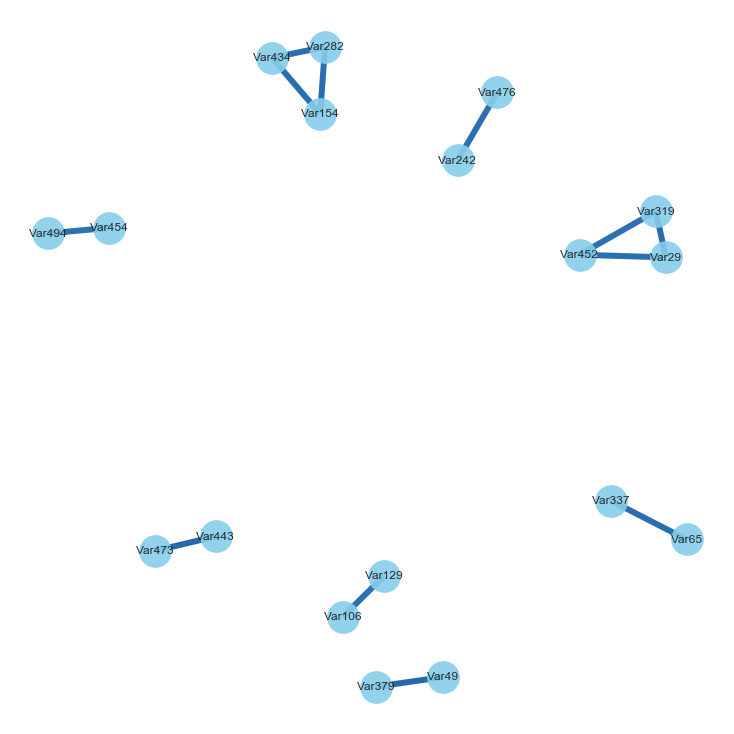

In [10]:
corr_columns_to_drop = correlated_variables(X_train, 0.95, 1)
X_train_transformed = X_train.drop(columns=corr_columns_to_drop)

### Filtrowanie 

In [11]:
def univariate_filter(X_train, y_train, n):
    selected_chi2 = SelectKBest(chi2, k=n).fit(X_train, y_train)
    selected_mut_info = SelectKBest(mutual_info_classif, k=n).fit(X_train, y_train)
    
    joined_logical_mask = np.logical_and(selected_chi2.get_support(), selected_mut_info.get_support())
    print(f"{joined_logical_mask.astype(np.int).sum()} features selected")
    return X_train.columns[joined_logical_mask]

In [12]:
filtered_columns = univariate_filter(X_train_transformed, y_train, 400)
X_train_transformed = X_train_transformed[filtered_columns]

321 features selected


### Podział zbioru na treningowy i testowy

In [13]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_transformed, y_train, test_size = 0.2, random_state=seed)

### Metoda z paczki "boruta"

In [14]:
rfc = RandomForestClassifier(n_estimators=500, class_weight="balanced", n_jobs=num_cpus)
feature_selector = boruta.BorutaPy(rfc, n_estimators="auto", verbose=0, random_state=seed)

In [15]:
feature_selector.fit(X_train_transformed.values, y_train.values)

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True,
                                          class_weight='balanced',
                                          criterion='gini', max_depth=None,
                                          max_features='auto',
                                          max_leaf_nodes=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=44, n_jobs=4,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x000001BD3C217798>,
                                          verbose=0, warm_start=False),
         max_

In [16]:
filtered = X_train_cv.columns[feature_selector.support_]
X_train_lgb = X_train_cv[filtered]
X_test_lgb = X_test_cv[filtered]
X_test_lgb.head()

,Var129,Var282,Var319,Var337,Var339,Var379,Var473,Var476,Var494
1342,477,529,501,527,481,443,485,416,622
1338,474,451,431,609,638,589,546,392,592
189,463,444,463,568,632,453,538,365,493
1332,463,426,477,542,660,415,534,380,479
1816,478,510,531,623,504,557,443,427,499


In [ ]:
class lgbOptimizer():
    def __init__(self, X_train, y_train, X_test, y_test, const_params, nfolds, n_iter, early_stopping):
        self.train_data = lgb.Dataset(data=X_train.values, label=y_train.values)

    
    def lgb_cross_validation(X_train, y_train, params_dict, const_params, nfold=5, n_iter=500, early_stopping_rounds=50):
    lgb_data = lgb.Dataset(data=X_train.values, label=y_train.values)
    results = pd.DataFrame(columns=["params", "ba_mean", "ba_std", "auc_mean", "auc_std", "num_iters"])
    params_grid = list(ParameterGrid(params_dict))
    for it in tqdm(range(len(params_grid))):
        params = params_grid[it]
        cv = lgb.cv(
            params={**params, **const_params},
            train_set=lgb_data,
            num_boost_round=n_iter, 
            nfold=nfold,
            metrics="auc",
            stratified=True,
            shuffle=True,
            feval=bal_ac_lgb,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=0
        )
        cv_df = pd.DataFrame(cv)
        cv_best_result = cv_df.iloc[-1,:]
        num_iters = cv_df.shape[0]
        results.loc[it] = [params, cv_best_result["ba-mean"], cv_best_result["ba-stdv"], cv_best_result["auc-mean"],
                       cv_best_result["auc-stdv"], num_iters]
    return results 

### CV

In [17]:
def lgb_cross_validation(X_train, y_train, params_dict, const_params, nfold=5, n_iter=500, early_stopping_rounds=50):
    lgb_data = lgb.Dataset(data=X_train.values, label=y_train.values)
    results = pd.DataFrame(columns=["params", "ba_mean", "ba_std", "auc_mean", "auc_std", "num_iters"])
    params_grid = list(ParameterGrid(params_dict))
    for it in tqdm(range(len(params_grid))):
        params = params_grid[it]
        cv = lgb.cv(
            params={**params, **const_params},
            train_set=lgb_data,
            num_boost_round=n_iter, 
            nfold=nfold,
            metrics="auc",
            stratified=True,
            shuffle=True,
            feval=bal_ac_lgb,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=0
        )
        cv_df = pd.DataFrame(cv)
        cv_best_result = cv_df.iloc[-1,:]
        num_iters = cv_df.shape[0]
        results.loc[it] = [params, cv_best_result["ba-mean"], cv_best_result["ba-stdv"], cv_best_result["auc-mean"],
                       cv_best_result["auc-stdv"], num_iters]
    return results   

### Wyniki uzyskane na Google Colab

In [ ]:
parameters = {
    "max_depth": [-1, 3, 5, 7],
    "max_bin": [100, 200, 255, 350],
    "learning_rate": [0.02, 0.03, 0.04],
    "num_leaves": [20, 31, 40, 50],
    "bagging_fraction": [0.9, 0.95, 1],
    "bagging_freq":[3, 10, 100],
    "lambda_l2": [0, 0.5, 1, 2]
}

In [25]:
grid_results = pd.read_csv("grid_search_results.csv")
grid_results.head()

,params,ba_mean,ba_std,auc_mean,auc_std,num_iters
0,"{'bagging_fraction': 0.9, 'bagging_freq': 3, '...",0.858517,0.013459,0.925274,0.010228,300
1,"{'bagging_fraction': 0.9, 'bagging_freq': 3, '...",0.865089,0.014421,0.931119,0.011325,268
2,"{'bagging_fraction': 0.9, 'bagging_freq': 3, '...",0.874511,0.010347,0.936431,0.009511,349
3,"{'bagging_fraction': 0.9, 'bagging_freq': 3, '...",0.865683,0.013661,0.932664,0.011599,223
4,"{'bagging_fraction': 0.9, 'bagging_freq': 3, '...",0.799929,0.012648,0.872650,0.010831,384


In [26]:
best = grid_results.sort_values("ba_mean", ascending=False).iloc[0, :]
best_params = best["params"]
num_iter = best["num_iters"]
best_params

"{'bagging_fraction': 0.9, 'bagging_freq': 10, 'lambda_l2': 1, 'learning_rate': 0.04, 'max_bin': 200, 'max_depth': -1, 'num_leaves': 50}"

In [22]:
best_params = {'bagging_fraction': 0.9, 'bagging_freq': 10, 'lambda_l2': 1, 'learning_rate': 0.04, 'max_bin': 200, 'max_depth': -1, 'num_leaves': 50}

### Dotrenowanie

In [18]:
const_parameters = {
    "objective": "binary",
    "n_jobs": num_cpus,
    "bagging_freq": 10
}

parameters2 = {
    "max_bin": [150, 180, 200, 255],
    "learning_rate": [0.02, 0.03, 0.04],
    "num_leaves": [50, 60, 70, 80],
    "bagging_fraction": [0.8, 0.85, 0.9, 1],
    "lambda_l2": [0, 0.5, 1, 2]
}

In [19]:
results = lgb_cross_validation(X_train_lgb, y_train_cv, parameters2, const_parameters, 4)

In [28]:
best = results.sort_values("ba_mean", ascending=False).iloc[0, :]
best_params = best["params"]
num_iter = best["num_iters"]
best_params

{'bagging_fraction': 0.85,
 'lambda_l2': 0.5,
 'learning_rate': 0.04,
 'max_bin': 200,
 'num_leaves': 60}

In [ ]:
best_params = {
    'bagging_fraction': 0.85,
    'lambda_l2': 0.5,
    'learning_rate': 0.04,
    'max_bin': 200,
    'num_leaves': 60
}

### LightGBM model

In [24]:
lgb_data = lgb.Dataset(data=X_train_lgb.values, label=y_train_cv.values)

#### Trening CV na zbiorze treningowym

In [25]:
cv = lgb.cv(
    params={**best_params, **const_parameters},
    train_set=lgb_data,
    num_boost_round=500, 
    nfold=4,
    metrics="auc",
    feval=bal_ac_lgb,
    stratified=True,
    shuffle=True,
    early_stopping_rounds=50,
    verbose_eval=5
)

[5]	cv_agg's auc: 0.852483 + 0.0408439	cv_agg's ba: 0.784238 + 0.0323957
[10]	cv_agg's auc: 0.867863 + 0.034264	cv_agg's ba: 0.795819 + 0.0359976
[15]	cv_agg's auc: 0.883571 + 0.0329005	cv_agg's ba: 0.815756 + 0.0390269
[20]	cv_agg's auc: 0.891891 + 0.0238276	cv_agg's ba: 0.821405 + 0.0293532
[25]	cv_agg's auc: 0.897232 + 0.0218461	cv_agg's ba: 0.819772 + 0.0289325
[30]	cv_agg's auc: 0.900196 + 0.0212782	cv_agg's ba: 0.824753 + 0.0274368
[35]	cv_agg's auc: 0.904439 + 0.0217081	cv_agg's ba: 0.830926 + 0.0296596
[40]	cv_agg's auc: 0.905546 + 0.0223712	cv_agg's ba: 0.836571 + 0.0284486
[45]	cv_agg's auc: 0.90738 + 0.0224435	cv_agg's ba: 0.840216 + 0.0284052
[50]	cv_agg's auc: 0.910131 + 0.0215474	cv_agg's ba: 0.844024 + 0.0274121
[55]	cv_agg's auc: 0.912267 + 0.0205268	cv_agg's ba: 0.848373 + 0.0284694
[60]	cv_agg's auc: 0.914653 + 0.019403	cv_agg's ba: 0.85144 + 0.0234729
[65]	cv_agg's auc: 0.916647 + 0.0195894	cv_agg's ba: 0.85755 + 0.0211996
[70]	cv_agg's auc: 0.917278 + 0.0194553	cv_a

#### Trening na całym zbiorze treningowym z ewaulacją na testowym

In [26]:
test_data = lgb.Dataset(data=X_test_lgb.values, label=y_test_cv.values)
lgb_classifier = lgb.train(
    {**best_params, **const_parameters, "num_iterations": num_iter}, 
    train_set=lgb_data, 
    feval=bal_ac_lgb, 
    valid_sets=test_data, 
    verbose_eval=5
)

[5]	valid_0's binary_logloss: 0.61467	valid_0's ba: 0.808318
[10]	valid_0's binary_logloss: 0.560949	valid_0's ba: 0.815626
[15]	valid_0's binary_logloss: 0.527068	valid_0's ba: 0.801021
[20]	valid_0's binary_logloss: 0.500784	valid_0's ba: 0.789211
[25]	valid_0's binary_logloss: 0.47448	valid_0's ba: 0.814626
[30]	valid_0's binary_logloss: 0.451193	valid_0's ba: 0.814781
[35]	valid_0's binary_logloss: 0.433498	valid_0's ba: 0.822383
[40]	valid_0's binary_logloss: 0.421026	valid_0's ba: 0.8322
[45]	valid_0's binary_logloss: 0.406221	valid_0's ba: 0.849785
[50]	valid_0's binary_logloss: 0.393141	valid_0's ba: 0.844638
[55]	valid_0's binary_logloss: 0.377453	valid_0's ba: 0.84964
[60]	valid_0's binary_logloss: 0.364379	valid_0's ba: 0.854642
[65]	valid_0's binary_logloss: 0.354913	valid_0's ba: 0.84964
[70]	valid_0's binary_logloss: 0.35078	valid_0's ba: 0.860644
[75]	valid_0's binary_logloss: 0.342681	valid_0's ba: 0.862634
[80]	valid_0's binary_logloss: 0.335544	valid_0's ba: 0.862384


In [32]:
y_pred_lgb = lgb_classifier.predict(X_test_lgb)
balanced_accuracy(y_test_cv, np.round(y_pred_lgb))

0.883364602876798

### LinearRegression - Lasso L1 reg

In [35]:
lasso_model = LogisticRegressionCV(cv=4, penalty="l1", scoring="balanced_accuracy", solver="liblinear", n_jobs=num_cpus)

In [36]:
lasso_model.fit(X_train_cv, y_train_cv)

LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=4, penalty='l1',
                     random_state=None, refit=True, scoring='balanced_accuracy',
                     solver='liblinear', tol=0.0001, verbose=0)

In [42]:
y_pred_lasso = lasso_model.predict_proba(X_test_cv)[:,1]
balanced_accuracy(y_test_cv, np.round(y_pred_lasso))

0.5930033269482811

In [43]:
coefs = lasso_model.coef_.ravel()
features_mask = [True if i!=0 else False for i in coefs]
X_train_cv.columns[features_mask]

Index(['Var11', 'Var14', 'Var50', 'Var126', 'Var200', 'Var205', 'Var225',
       'Var278', 'Var286', 'Var297', 'Var314', 'Var337', 'Var348', 'Var379',
       'Var412', 'Var416', 'Var419', 'Var431', 'Var463', 'Var468', 'Var476'],
      dtype='object')

### Finalna predykcja

In [55]:
X_test_final = pd.read_csv("artificial_valid.data", sep=" ", header=None).iloc[:, 0:500].rename(str, axis="columns")
X_test_final.columns = ["Var{}".format(i+1) for i in range(X_train.shape[1])]
X_test_final = X_test_final[filtered]

In [47]:
X_train_final = X_train_lgb.append(X_test_lgb)
y_train_final = y_train_cv.append(y_test_cv)
lgb_data = lgb.Dataset(data=X_train_final.values, label=y_train_final.values)

#### Trening CV na całym zbiorze treningowym

In [51]:
lgb_classifier = lgb.train(
    {**best_params, **const_parameters, "num_iterations": num_iter}, 
    train_set=lgb_data, 
    feval=bal_ac_lgb, 
    verbose_eval=5
)

In [56]:
y_pred_final = lgb_classifier.predict(X_test_final)

#### Zapis wyniku

In [57]:
np.savetxt("WOJCEL_artificial_prediction.txt", y_pred_final, fmt='%.18f',)

## Krzywe ROC

In [60]:
fpr1, tpr1, thresholds = roc_curve(y_test_cv, y_pred_lgb)
fpr2, tpr2, thresholds = roc_curve(y_test_cv, y_pred_lasso)
x = np.linspace(0, 1, 100)

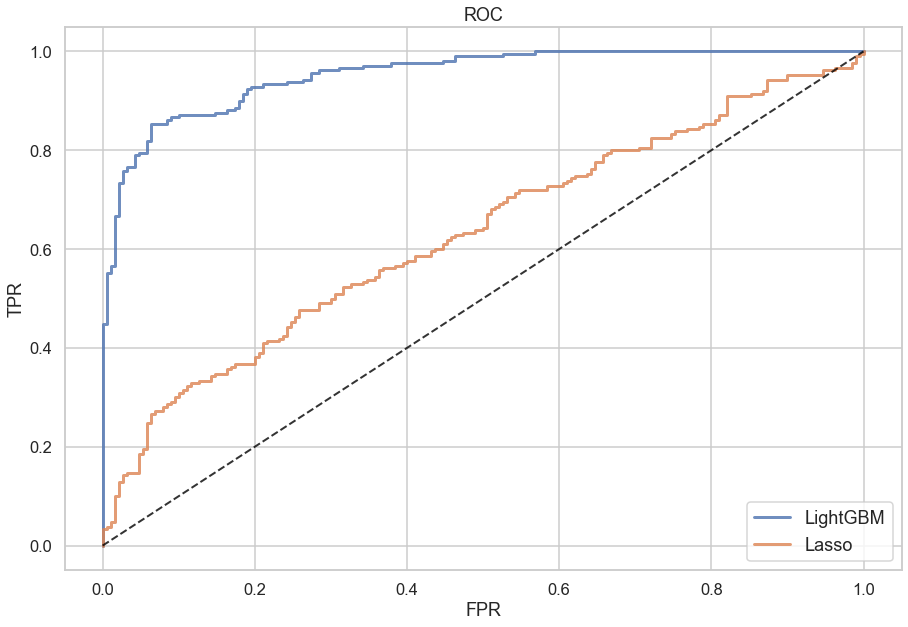

In [72]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize=(15,10))
plt.plot(fpr1, tpr1, linewidth = 3, alpha = 0.8)
plt.plot(fpr2, tpr2, linewidth = 3, alpha = 0.8)
plt.plot(x, x, linewidth=2, alpha=0.8, linestyle="--", color="black")
plt.legend(['LightGBM', 'Lasso'], loc='lower right', prop={'size': 18})
plt.title("ROC", size = 18)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## Ważność zmiennych shap